# Uniforming cell label annotations

In this notebook we collapse and save cell annotations from fetal datasets. Annotations were either downloaded from original publications or provided by the dataset authors (for skin, yolk sac, spleen) 

In [3]:
import os,sys
import scanpy as sc 
import anndata
import numpy as np
import pandas as pd
import re

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Uniform labelling 

Here we translate detailed cell labels for each organ to a uniform labelling to use to guide data integration. Translations from old to new labels are saved in `*_annot_lvls.csv` files.

In [6]:
annot_dir = '../../metadata/old_annotations/'

#### Thymus cells

In [7]:
th_annot_lvls = {
    "SP T CELL":['CD8+T', 'CD4+T', 'CD8αα(I)', 'αβT(entry)', 'CD8αα(II)', 'Th17', 'γδT', 'CD8+Tmem','CD4+Tmem', 'CD4+CTL', 'Tfh', 'CD4+PD1'],
    "DP T CELL":['DP(P)', 'DP(Q)'],
    "DN T CELL":['DN(Q)', 'DN(P)', "DN(early)"],
    "TREG":['Treg(diff)', 'T(agonist)', "Treg"],
    "MONOCYTE":["Mono"],
    "B CELL":["B_naive", 'B_memory', 'B_plasma'],
    "PRE PRO B CELL":["B_pro/pre"],
    "DC":['DC2', 'DC1',  'aDC1', 'aDC3', 'aDC2'],
    "PDC":['pDC'],
    "NK T": ['NKT'],
    "MACROPHAGE":["Mac"],
    "NEUTROPHIL-MYELOID PROGENITOR":['NMP'],
    "FIBROBLAST":["Fb_1", "Fb_2", "Fb_cycling"],
    "NK":["NK"],
    "MAST CELL":["Mast"],
    "LYMPHOID PROGENITOR":["ETP"],
    "ILC":["ILC3"],
    'ERYTHROCYTE':["Ery"],
    'SMOOTH MUSCLE/PERICYTE':["VSMC"],
    'EPITHELIUM':['mTEC(I)','TEC(neuro)', 'mTEC(II)','cTEC','mcTEC', 'TEC(myo)', 'mTEC(III)','mTEC(IV)', 'Epi_GCM2'],
    'ENDOTHELIAL CELL':["Endo"],
    'MEGAKARYOCYTE':['Mgk'],
    'LYMPHATIC':["Lymph"],
 }

th_lvls_df = pd.DataFrame(pd.concat({k: pd.Series(v) for k, v in th_annot_lvls.items()})).reset_index()
th_lvls_df = th_lvls_df[[0,"level_0"]]
th_lvls_df.columns = ['original_cell_type',"updated_cell_type"]
th_lvls_df.index=th_lvls_df["original_cell_type"]
th_lvls_df = th_lvls_df.drop("original_cell_type",1)
th_lvls_df.to_csv(annot_dir + 'th_annot_lvls.csv')

#### Gut cells

In [8]:
gu_annot = pd.read_csv(annot_dir + "gu_annot.csv")

In [9]:
gu_lvls_df = pd.DataFrame(gu_annot["cell.labels"].unique(), columns=['original_cell_type'])

gut_labels = [x.upper() for x in gu_annot["cell.labels"].unique()]
gut_labels = ["ENDOTHELIAL CELL" if "ENDOTHELIAL" in x else x for x in gut_labels]
gut_labels = ["ERYTHROCYTE" if "ERYTHROBLAST" in x else x for x in gut_labels]
gut_labels = ["NEUTROPHIL" if "NEUTROPHIL" in x else x for x in gut_labels]
gut_labels = ["DC" if "DC" in x and x!="PDC" else x for x in gut_labels]
gut_labels = ["FIBROBLAST" if "STROMA" in x else x for x in gut_labels]
gut_labels = ['LYMPHOID PROGENITOR' if x=="CLP" else x for x in gut_labels]
gut_labels = ["ENTEROENDOCRINE CELL" if "EEC" in x else x for x in gut_labels]
gut_labels = ["GLIA" if "GLIA" in x else x for x in gut_labels]
gut_labels = ["NEURON" if "NEURON" in x else x for x in gut_labels]
gut_labels = ["ENDOTHELIAL CELL" if "ENDOTHELIUM" in x else x for x in gut_labels]
gut_labels = ["ENTEROCYTE" if "ENTEROCYTE" in x else x for x in gut_labels]
gut_labels = ["CD16 MYELOID" if "MYELOID" in x else x for x in gut_labels]
gut_labels = ["SP T CELL" if x in ["CYCLING T", 'SELL+ CD4 T', 'SELL+ CD8 T'] else x for x in gut_labels]
gut_labels = ["NEURAL CREST" if "ENCC" in x else x for x in gut_labels]
gut_labels = ["ILC PRECURSOR" if "ILCP" in x else x for x in gut_labels]
gut_labels = ['LTI/ILC3' if 'LTI-LIKE ILC3' in x else x for x in gut_labels]
gut_labels = ['NK T' if 'NK/T' in x else x for x in gut_labels]
gut_labels = ['NK T' if 'NK T CELL' in x else x for x in gut_labels]
gut_labels = ['NK' if 'NK CELL' in x else x for x in gut_labels]
gut_labels = ['MACROPHAGE' if 'MACROPHAGE' in x else x for x in gut_labels]
gut_labels = ['MONOCYTE' if 'MONOCYTE' in x else x for x in gut_labels]
gut_labels = ['MAST CELL' if 'MAST' in x else x for x in gut_labels]
gut_labels = ['SCHWANN CELLS' if 'SCHWANN' in x else x for x in gut_labels]
gut_labels = ['SCHWANN CELLS' if 'SCP' in x else x for x in gut_labels]
gut_labels = ['B CELL' if 'IMMATURE B' in x else x for x in gut_labels]
gut_labels = ['PRE B CELL' if 'PRE-B' in x else x for x in gut_labels]
gut_labels = ['PRO B CELL' if 'PRO-B' in x else x for x in gut_labels]
gut_labels = ['SMOOTH MUSCLE/PERICYTE' if 'SMC' in x else x for x in gut_labels]

gu_lvls_df["updated_cell_type"] = gut_labels

gu_lvls_df.index = gu_lvls_df["original_cell_type"]
gu_lvls_df = gu_lvls_df.drop("original_cell_type",1)
gu_lvls_df.to_csv(annot_dir + 'gu_annot_lvls.csv')

#### kidney cells
I use the compartment annotation from the original file to group nephron annotations. 
N.B. in the original file there was a grand total of 12 cells with duplicated barcodes: I decided to exclude these

In [10]:
ki_annot = pd.read_csv(annot_dir + "ki_annot.csv")

In [ ]:
ki_lvls_df = pd.DataFrame(ki_annot["cell.labels"].unique(), columns=['original_cell_type'])

ki_labels = [x.upper() for x in ki_annot["cell.labels"].unique()]

## Pick kidney specific labels
ki_anno_df = pd.read_csv(annot_dir + "original_files/fetal_kidney_anno.csv", index_col=0)
ki_anno_df = ki_anno_df[["celltype", "compartment"]].drop_duplicates()
ki_anno_df.celltype = [x.upper() for x in ki_anno_df.celltype]
fetal_nephron_labels = ki_anno_df[ki_anno_df.compartment=="fetal_nephron"]["celltype"].values

ki_labels = ['MACROPHAGE' if 'MACROPHAGE' in x else x for x in ki_labels]
ki_labels = ["SP T CELL" if " T CELL" in x else x for x in ki_labels]
ki_labels = ["NK" if "NK" in x else x for x in ki_labels]
ki_labels = ["B CELL" if "B CELL" in x else x for x in ki_labels]
ki_labels = ['FIBROBLAST' if x in ['PROLIFERATING FIBROBLAST', 'FIBROBLAST 1', 'FIBROBLAST 2'] else x for x in ki_labels]
ki_labels = ['MYOFIBROBLAST' if x in ['PROLIFERATING MYOFIBROBLAST', 'MYOFIBROBLAST 1', 'MYOFIBROBLAST 2'] else x for x in ki_labels]
ki_labels = ['DC' if "CDC" in x else x for x in ki_labels]
ki_labels = ['PDC' if "PDC" in x else x for x in ki_labels]
ki_labels = ['MONOCYTE' if "MONOCYTE" in x else x for x in ki_labels]
ki_labels = ['STROMA PROGENITOR' if "STROMA PROGENITOR" in x else x for x in ki_labels]
ki_labels = ['MAST CELL' if "MAST" in x else x for x in ki_labels]
ki_labels = ['ILC' if x=="INNATE LIKE LYMPHOCYTE" in x else x for x in ki_labels]
ki_labels = ['ENDOTHELIAL CELL' if "ENDOTHELIUM" in x else x for x in ki_labels]
ki_labels = ['NEPHRON' if x in fetal_nephron_labels else x for x in ki_labels]

ki_lvls_df["updated_cell_type"] = ki_labels

ki_lvls_df.index = ki_lvls_df["original_cell_type"]
ki_lvls_df = ki_lvls_df.drop("original_cell_type",1)
ki_lvls_df.to_csv(annot_dir + 'ki_annot_lvls.csv')

#### Skin cells

In [ ]:
sk_annot = pd.read_table(annot_dir + "original_files/fetal_skin.annotation.20200829.for_Issac.tsv", header=None)

In [ ]:
sk_labels = [x.upper() for x in sk_annot.iloc[:,1].unique()]

sk_lvls_df = pd.read_csv(annot_dir + "original_files/sk_annot_lvls.csv")
sk_lvls_df.iloc[:,1] = [x.upper() for x in sk_lvls_df.iloc[:,1]]
sk_lvls_df.iloc[:,0] = [x.upper() for x in sk_lvls_df.iloc[:,0]]

sk_labels = [sk_lvls_df.updated_cell_type[sk_lvls_df.original_cell_type==x] if x in sk_lvls_df.original_cell_type else x for x in sk_labels]

sk_lvls_df = pd.DataFrame(sk_annot.iloc[:, 1].unique(), columns=['original_cell_type'])

sk_labels = ['GMP' if 'GRANULOCYTE PROGENITOR' in x else x for x in sk_labels]
sk_labels = ["GLIA" if "GLIA" in x else x for x in sk_labels]
sk_labels = ["FIBROBLAST" if "FIBROBLAST" in x else x for x in sk_labels]
sk_labels = ["ENDOTHELIAL CELL" if "ENDOTHELIUM" in x else x for x in sk_labels]
sk_labels = ["MONOCYTE/DC PRECURSOR" if "MONOCYTE PRECUSOR" in x else x for x in sk_labels]
sk_labels = ["NK" if x=="NK CELL" else x for x in sk_labels]
sk_labels = ["NK T" if x=="NK T CELL" else x for x in sk_labels]
sk_labels = ["SMOOTH MUSCLE/PERICYTE" if x=="SMOOTH MUSCLE" else x for x in sk_labels]
sk_labels = ["MUSCLE" if x=="SKELETAL MUSCLE" else x for x in sk_labels]
sk_labels = ["LTI/ILC3" if x in ["LTI", "ILC3"] else x for x in sk_labels]
sk_labels = ["MONOCYTE/MACROPHAGE" if x in ["MAC-MONO"] else x for x in sk_labels]
sk_labels = ["LANGERHAN CELLS" if x in ['LANGERHANS CELL'] else x for x in sk_labels]
sk_labels = ["NEURON" if x in ['NEURONAL CELLS'] else x for x in sk_labels]
sk_labels = ["SCHWANN CELLS" if x in ['SCHWANN CELL'] else x for x in sk_labels]
sk_labels = ["DC" if x in ['ASDC'] else x for x in sk_labels]
sk_labels = ["KERATINOCYTES" if x in ['SUPRABASAL KC', "HF KC"] else x for x in sk_labels]

sk_lvls_df["updated_cell_type"] = sk_labels

sk_lvls_df.index = sk_lvls_df["original_cell_type"]
sk_lvls_df = sk_lvls_df.drop("original_cell_type",1)
sk_lvls_df.to_csv(annot_dir + 'sk_annot_lvls.csv')

### Merge uniformed labels

In [12]:
annot_files = [x for x in os.listdir(annot_dir) if "annot.csv" in x]
lvls_annot_files = [x for x in os.listdir(annot_dir) if "annot_lvls" in x]

organs = [x.split("_annot")[0] for x in annot_files]

Load all translations to fix errors from manual annotation

In [13]:
lvls_labels_full = pd.DataFrame()
for file in lvls_annot_files:
    ## Read labels file
    organ = file.split("_")[0]
    lvls_labels_df = pd.read_csv(annot_dir + file)
    lvls_labels_df["organ"] = organ
    lvls_labels_full = pd.concat([lvls_labels_full, lvls_labels_df], 0)

In [14]:
lvls_labels_full["uniform_label"] = [x.upper() for x in lvls_labels_full.updated_cell_type]

## Fix some typos
lvls_labels_full["uniform_label"] = ['KUPFFER CELL' if x=='KUPFFER ELL' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['ENDOTHELIAL CELL' if x=='ENDOTHELIUM' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['EO/BASO/MAST PRECURSOR' if x=='EO/BASE/MAST PRECURSOR' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['MAST CELL' if x=='MAST CEL' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['NEUTROPHIL' if x=='NEUTROPHILE' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['NEUTROPHIL-MYELOID PROGENITOR' if x in ['NEUT-MYELOID PRECURSOR', 'NEUTROPHIL MYELOID PROGENITOR'] else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['PRE PRO B CELL' if x=='PRE PRO B' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['PRO B CELL' if x=='PRO B' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['PRE B CELL' if x=='PRE B' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['NEURAL CREST' if 'NEURAL CREST' in x else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['GLIA' if 'GLIA' in x else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['SP T CELL' if x in ["CD8 T CELL", "CD4 T CELL", "T CELL"] else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['ERYTHROID' if x in ['ERYTHROID','YS ERYTHROID'] else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['DC' if x in ['DC1','DC2'] else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['ILC' if x=='ILC2' else x for x in lvls_labels_full["uniform_label"]]
lvls_labels_full["uniform_label"] = ['ILC' if x=='ILC2' else x for x in lvls_labels_full["uniform_label"]]

lvls_labels_full.reset_index(inplace=True)

In [15]:
## Save uniform labelling 
lvls_labels_full[['original_cell_type', "organ", "uniform_label"]].to_csv(annot_dir + 'uniform_lvls.csv')

### Plot

In [16]:
lvls_labels_full = pd.read_csv(annot_dir + 'uniform_lvls.csv')

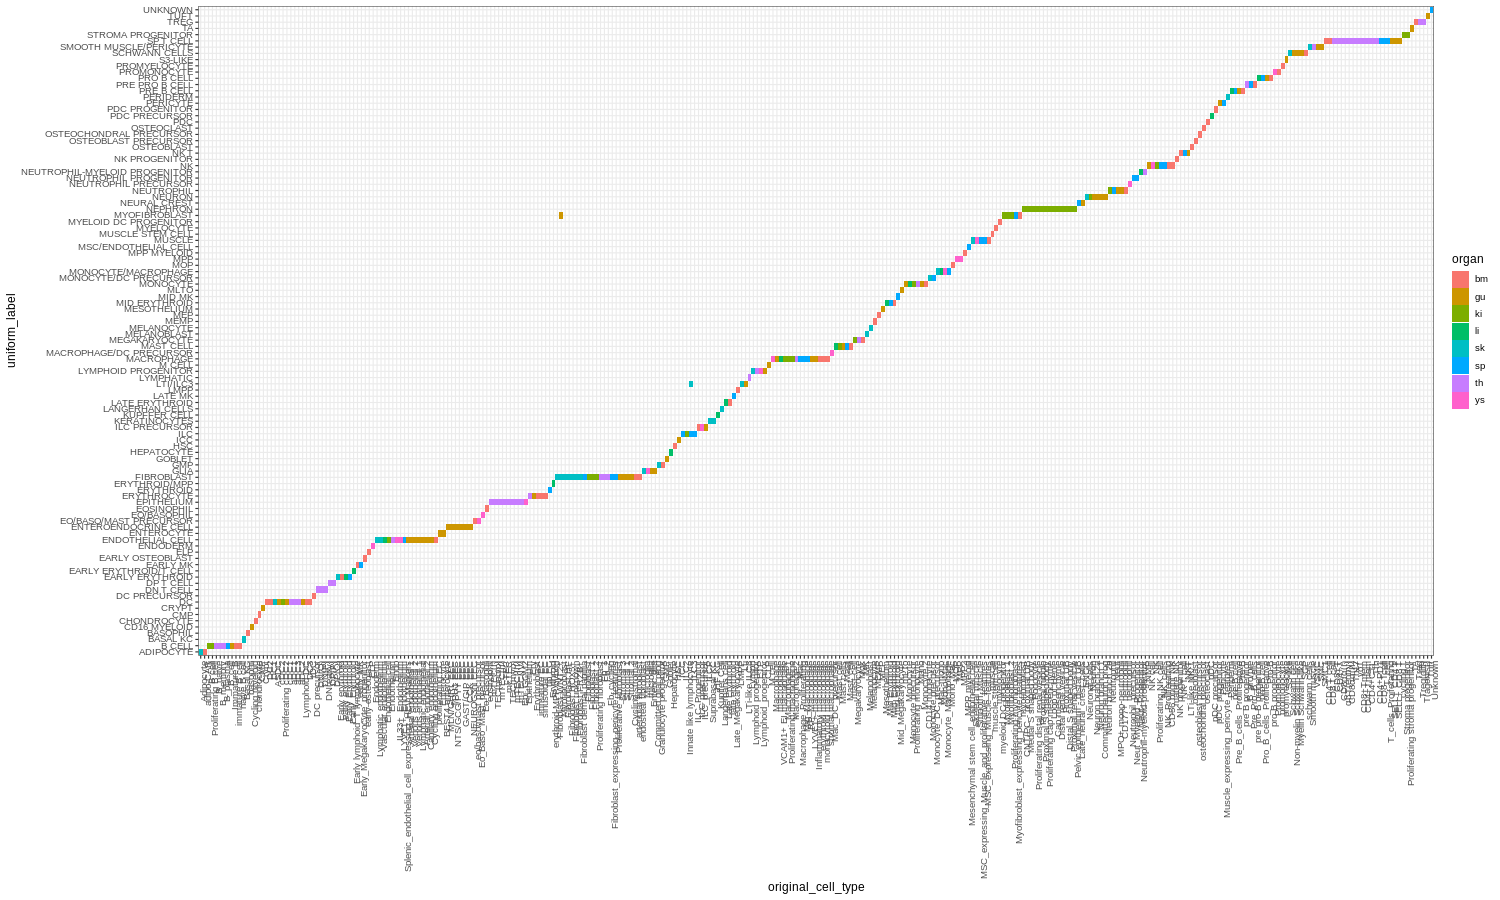

In [30]:
%%R -i lvls_labels_full -w 1500 -h 900

lvls_labels_full %>%
arrange(uniform_label) %>%
mutate(original_cell_type=factor(original_cell_type, levels=unique(original_cell_type))) %>%
ggplot(aes(original_cell_type, uniform_label, fill=organ)) +
geom_tile() +
theme_bw(base_size=12) +
theme(axis.text.x=element_text(angle=90, hjust=1))

Add uniform labels to full cell annotation

In [18]:
cell_labels_full = pd.DataFrame()
for organ,file in zip(organs, annot_files):
    ## Read labels file
    orig_labels_df = pd.read_csv(annot_dir + file,  index_col=0)
    orig_labels_df["organ"] = organ
    
    if os.path.exists(annot_dir + organ + "_annot_lvls.csv"):
        ## Read labels translations
        new_labels = lvls_labels_full[lvls_labels_full.organ==organ]
        new_labels.index = new_labels["original_cell_type"]
        ## Add updated labels
        orig_labels_df['uniform_label'] = new_labels.loc[orig_labels_df["cell.labels"]]['uniform_label'].values
    
    cell_labels_full = pd.concat([cell_labels_full, orig_labels_df], 0)

In [19]:
cell_labels_full.to_csv(annot_dir + "uniform_labels_full.csv")

In [20]:
labels_count = cell_labels_full.reset_index()[["uniform_label", "organ", "index"]].groupby(["uniform_label", "organ"]).count().reset_index()
labels_count.columns = ["uniform_label", "organ", "n_cells"]

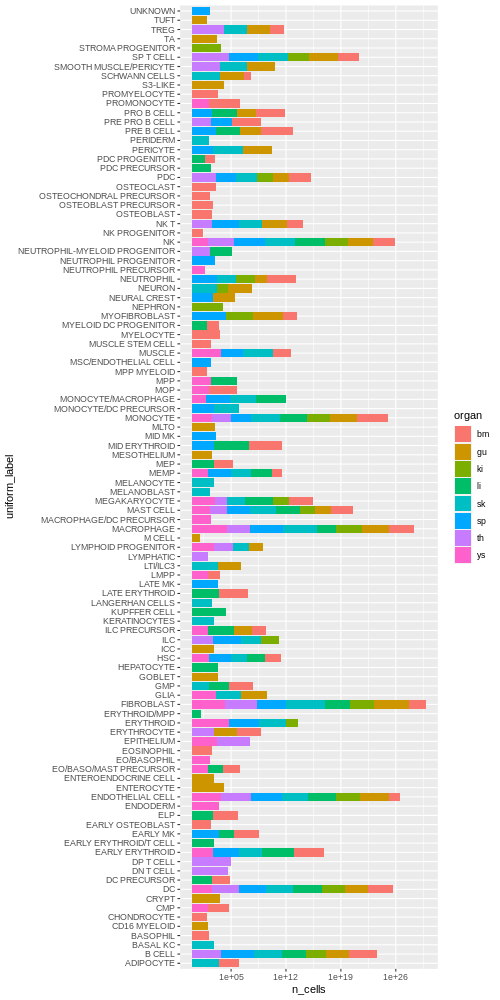

In [21]:
%%R -i labels_count -h 1000 -w 500
library(ggplot2)
library(dplyr)

labels_count %>%
ggplot(aes(uniform_label, n_cells, fill=organ)) +
geom_col() +
scale_y_log10() +
coord_flip()


### Add manually annotated level_0 

In [24]:
lvl0 = pd.read_csv("{a}/uniform_labels_lvl0_20210118.csv".format(a=annot_dir),  
                   index_col=0)
lvl0.index = lvl0.uniform_label
lvls_labels_full["uniform_label_lvl0"] = lvl0.loc[lvls_labels_full.uniform_label]["uniform_label_lvl0"].values
lvls_labels_full["uniform_label_expanded_merged"] = lvl0.loc[lvls_labels_full.uniform_label]["uniform_label_expanded_merged"].values

In [25]:
lvls_labels_full

,Unnamed: 0,original_cell_type,organ,uniform_label,uniform_label_lvl0,uniform_label_expanded_merged
0,0,Macrophage,sk,MACROPHAGE,MYELOID,MACROPHAGE
1,1,Monocyte,sk,MONOCYTE,MYELOID,MONOCYTE
2,2,Granulocyte progenitor,sk,GMP,HSC_MPP,GRANULOCYTE_MONOCYTE_PROGENITOR
3,3,DC2,sk,DC,MYELOID,DC
4,4,Microglia,sk,GLIA,GLIAL,GLIA
...,...,...,...,...,...,...
390,390,sinusoidal EC,bm,ERYTHROCYTE,ERYTHROID,ERYTHROID
391,391,stromal macrophage,bm,MACROPHAGE,MYELOID,MACROPHAGE
392,392,tDC,bm,DC,MYELOID,DC
393,393,tip EC,bm,ERYTHROCYTE,ERYTHROID,ERYTHROID


In [26]:
## Save uniform labelling 
lvls_labels_full[['original_cell_type', "organ", "uniform_label", "uniform_label_lvl0", "uniform_label_expanded_merged"]].to_csv(annot_dir + 'uniform_lvls.csv')

In [27]:
lvl0_matching = lvls_labels_full[['uniform_label', "uniform_label_lvl0", "uniform_label_expanded_merged"]].drop_duplicates()
lvl0_matching.index = lvl0_matching["uniform_label"] 
lvl0_full = lvl0_matching.loc[cell_labels_full["uniform_label"]][["uniform_label_lvl0", "uniform_label_expanded_merged"]]

In [28]:
cell_labels_full["uniform_label_lvl0"] = lvl0_full["uniform_label_lvl0"].values
cell_labels_full["uniform_label_expanded_merged"] = lvl0_full["uniform_label_expanded_merged"].values

In [29]:
cell_labels_full.to_csv(annot_dir + "uniform_labels_full.csv")